In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
import os
from skimage.morphology import label

Getting labels

In [39]:
lables = pd.read_csv('data/train_ship_segmentations_v2.csv')

In [4]:
lables.describe()

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


In [5]:
lables.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [43]:
print(f"Number of pictures: {len(lables['ImageId'].unique())}")
print(f"Images with at least one label: {len(lables['ImageId'].unique())-lables['EncodedPixels'].isnull().sum()}")
print(f"Total number of labels: {len(lables['EncodedPixels'])-lables['EncodedPixels'].isnull().sum()}")

Number of pictures: 192556
Images with at least one label: 42556
Total number of labels: 81723


Analyzing images sizes

In [7]:
img_sizes = []
img_names = []
for i in os.listdir("data/train_v2"):
    img_names.append(i)
    img_sizes.append(cv2.imread("data/train_v2/"+i).shape)

In [31]:
img_names = np.array(img_names)
img_shapes = np.array(img_sizes)

In [44]:
img_sizes=img_shapes[:,:2]
print(f"Image shape:{img_sizes[0]}")

Image shape:[768 768]


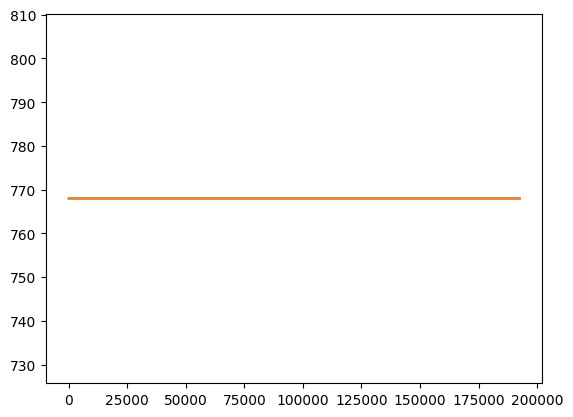

In [37]:
plt.plot(img_sizes)

All images are the same size, images do not require reshape

In [105]:
def mask_decoder(lable, shape = (768, 768)):
    splited = lable.split()
    starts, lengths = [np.asarray(x, dtype=np.longlong) for x in (splited[0:][::2], splited[1:][::2])]
    starts -=1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for low, high in zip(starts, ends):
        img[low:high] = 1
    return img.reshape(shape).T

In [106]:
def combine_masks(mask_list):
    masks = np.zeros((768,768), dtype=np.int32)
    for mask in mask_list:
        if isinstance(mask, str):
            masks += mask_decoder(mask)
    return np.expand_dims(masks, -1)

In [153]:
def mask_encoder(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:]!=pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [156]:
def multi_mask_encoder(img):
    labels = label(img[:, :, 0])
    return [mask_encoder(labels==k) for k in np.unique(labels[labels>0])]

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


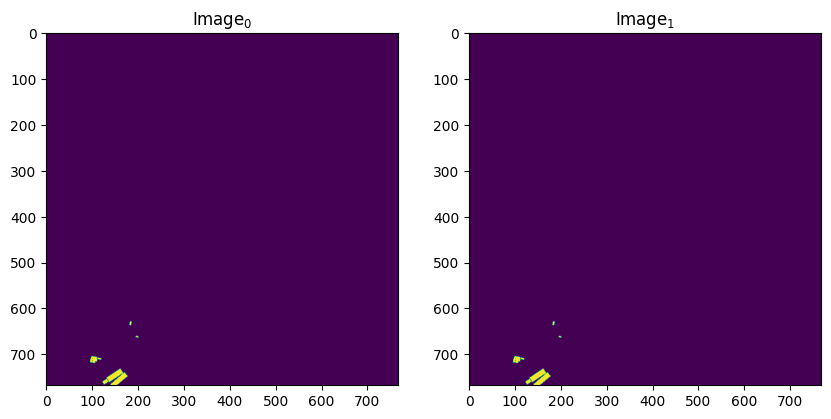

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = lables.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = combine_masks(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_mask_encoder(img_0)
img_1 = combine_masks(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))